In [34]:
import json
import string
from pathlib import Path
from PIL import Image

import numpy as np
import geopandas as gpd
import pandas as pd
import requests
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
from tqdm.notebook import tqdm
from youtube_transcript_api import YouTubeTranscriptApi
from wordcloud import WordCloud, STOPWORDS

pd.options.display.max_columns = None

DATA_DIR = Path().absolute().parent.parent / "data"

In [35]:
url_un_spreadsheet = 'https://docs.google.com/spreadsheets/d/1qtqfnRSW24j-XLN7SRKywDCuFatARCH8pUg1Rr6I2vI/export?format=csv'
response = requests.get(url_un_spreadsheet)
with open(DATA_DIR / 'UN Speeches.csv', 'wb') as f:
    f.write(response.content)

df_speech_url = pd.read_csv(DATA_DIR / "UN Speeches.csv")

In [36]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

def clean(doc: str) -> str:
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

def get_corpus_from_file(country: str, start: int = 0, end:int = 3600, path: Path = DATA_DIR / "2023") -> str:
    with open(path / f"{country}.json") as f:
        json_data = json.load(f)
    corpus = [x['text'] for x in json_data if x['start'] > start and x['start'] < end]
    large_corpus = ' '.join([x for x in corpus])
    return large_corpus

def get_transcript(video_id: str, start: str = None, end: str = None) -> list[str]:
    # TODO Add filter with start time and end time, to cut introductions.
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        corpus = [x['text'] for x in transcript]
        large_corpus = ' '.join([x for x in corpus])
        return transcript, large_corpus
    except Exception as e:
        print(e)
        return None, None

def get_video_url(country: str) -> str:
    if isinstance(df_speech_url[df_speech_url["country"] == country]["start"].values[0], str):
        h,m,s=df_speech_url[df_speech_url["country"] == country]["start"].values[0].split(":")
        seconds = int(h)*3600+int(m)*60+int(s)
        url = f'{df_speech_url[df_speech_url["country"] == country]["url"].values[0]}&t={seconds}'
        return url
    else:
        url = df_speech_url[df_speech_url["country"] == country]["url"].values[0]
        return url
    
def save_json(data: dict, country: str, output_path: Path = DATA_DIR / "2023"):
    with open(output_path / f"{country}.json", "w") as outfile:
        json.dump(data, outfile)

def download_speech_transcriptions(df_speech_url: pd.DataFrame, overwrite: bool = False):
    pbar = tqdm(df_speech_url.iterrows(), total=len(df_speech_url))
    for i, r in pbar:
        pbar.set_description(r['country'])
        if (DATA_DIR / "2023" / f"{r['country']}.json").is_file() and not overwrite:
            continue
        transcript, large_corpus = get_transcript(r['url'].split('?v=')[-1])
        if transcript:
            save_json(transcript, r['country'])

In [37]:
download_speech_transcriptions(df_speech_url, overwrite=False)

  0%|          | 0/142 [00:00<?, ?it/s]

In [ ]:
# Generate masks for the countries

# countries shape https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
geo_data = gpd.read_file(DATA_DIR / 'ne_110m_admin_0_countries.zip')

# Generate masks
pbar = tqdm(df_speech_url.iterrows(), total=len(df_speech_url))
for i, r in pbar:
    pbar.set_description(r['country'])
    if len(geo_data[geo_data['SOVEREIGNT']==r['country']]) > 0:
        ax = geo_data[geo_data['SOVEREIGNT']==r['country']].plot();
        ax.axis('off');
        ax.figure.savefig(DATA_DIR / "masks" / f"{r['country']}.jpg");
    else:
        print(f"{r['country']} not found.")

"""
Palau not found.
Monaco not found.
Marshall Islands not found.
Sao Tome & Principe not found.
Comoros not found.
Dominica not found.
Kiribati not found.
Micronesia not found.
Palestine not found.
Nauru not found.
Liechtenstein not found.
Mauritius not found.
Malta not found.
Barbados not found.
Andorra not found.
Saint Lucia not found.
Seychelles not found.
Antigua and Barbuda not found.
Grenada not found.
Tuvalu not found.
Tonga not found.
Singapore not found.
Bahrain not found.
Bahamas not found.
"""

<Axes: >

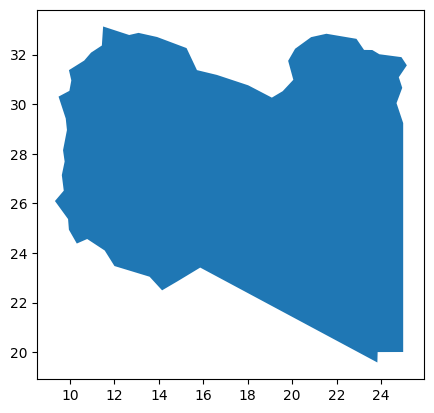

In [39]:
# geo_data[geo_data['SOV_A3'].isin(['COM'])]
# geo_data['SOVEREIGNT'].unique()
# geo_data[geo_data['SOVEREIGNT']=='United States of America']
geo_data[geo_data['SOVEREIGNT']=='Libya'].plot()

In [40]:
# Wordcloud generation
stopwords = set(STOPWORDS)

pbar = tqdm(df_speech_url.iterrows(), total=len(df_speech_url))
for i, r in pbar:
    pbar.set_description(r['country'])
    try:
        country_mask = np.array(Image.open(DATA_DIR / "masks" / f"{r['country']}.jpg"))
        wc = WordCloud(background_color="white", max_words=2000, mask=country_mask, stopwords=stopwords, contour_width=3, contour_color='steelblue')
        
        if isinstance(r['start'], str) and isinstance(r['end'], str):
            h_start, m_start, s_start = r['start'].values[0].split(':')
            start = int(h_start) * 60*60 + int(m_start)*60 + int(s_start)
            h_end, m_end, s_end = r['end'].values[0].split(':')
            end = int(h_end) * 60*60 + int(m_end)*60 + int(s_end)
            corpus = get_corpus_from_file(r['country'], start=start, end=end)
        elif isinstance(r['start'], str) :
            h, m, s = r['start'].values[0].split(':')
            start = int(h) * 60*60 + int(m)*60 + int(s)
            corpus = get_corpus_from_file(r['country'], start=start)
        else:
            corpus = get_corpus_from_file(r['country'])
        corpus = clean(corpus)
        wc.generate(corpus)
        wc.to_file(DATA_DIR / "wordclouds" / f"{r['country']}_words.png");
    except:
        pass

  0%|          | 0/142 [00:00<?, ?it/s]

In [41]:
# This is to download the stopwords
# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context
# # nltk.download('stopwords')
# nltk.download('wordnet')
# # nltk.download()

In [42]:
# from nltk.draw.dispersion import dispersion_plot
# import matplotlib.pyplot as plt
# plt.style.use('ggplot')

In [43]:
def dispersion_plot(text, words, ignore_case=False, title="Lexical Dispersion Plot"):
    """
    Generate a lexical dispersion plot.

    :param text: The source text
    :type text: list(str) or iter(str)
    :param words: The target words
    :type words: list of str
    :param ignore_case: flag to set if case should be ignored when searching text
    :type ignore_case: bool
    :return: a matplotlib Axes object that may still be modified before plotting
    :rtype: Axes
    """

    try:
        import matplotlib.pyplot as plt
    except ImportError as e:
        raise ImportError(
            "The plot function requires matplotlib to be installed. "
            "See https://matplotlib.org/"
        ) from e

    word2y = {
        word.casefold() if ignore_case else word: y
        # for y, word in enumerate((words))
        for y, word in enumerate(reversed(words))
    }
    xs, ys = [], []
    for x, token in enumerate(text):
        token = token.casefold() if ignore_case else token
        y = word2y.get(token)
        if y is not None:
            xs.append(x)
            ys.append(y)

    words = words[::-1]
    _, ax = plt.subplots()
    ax.plot(xs, ys, "|")
    ax.set_yticks(list(range(len(words))), words, color="C0")
    ax.set_ylim(-1, len(words))
    ax.set_title(title)
    ax.set_xlabel("Word Offset")
    return ax

# dispersion_plot(text, [str(w) for w, f in fdist.most_common(10)])

In [44]:
# geo_data[geo_data['ADMIN']=="Chile"][['ADMIN', 'POP_EST', 'POP_RANK', 'GDP_MD', 'ECONOMY', 'INCOME_GRP', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB']]

In [45]:
# geo_data.head()